<a href="https://colab.research.google.com/github/ChrisMath26/AAyCD/blob/main/Clasificacion_RL/Logit_simple_final_con_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-0e2230d72e32>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CONSUMADO'] = np.where(df['CLASIFICACION_DE_LA_CONDUCTA'] == 'Suicidio consumado', 1, 0)


              EDAD    CONSUMADO
count  1135.000000  1135.000000
mean     41.455507     0.378855
std      22.261265     0.485316
min       8.000000     0.000000
25%      22.000000     0.000000
50%      38.000000     0.000000
75%      60.000000     1.000000
max      94.000000     1.000000
CONSUMADO
0    705
1    430
Name: count, dtype: int64


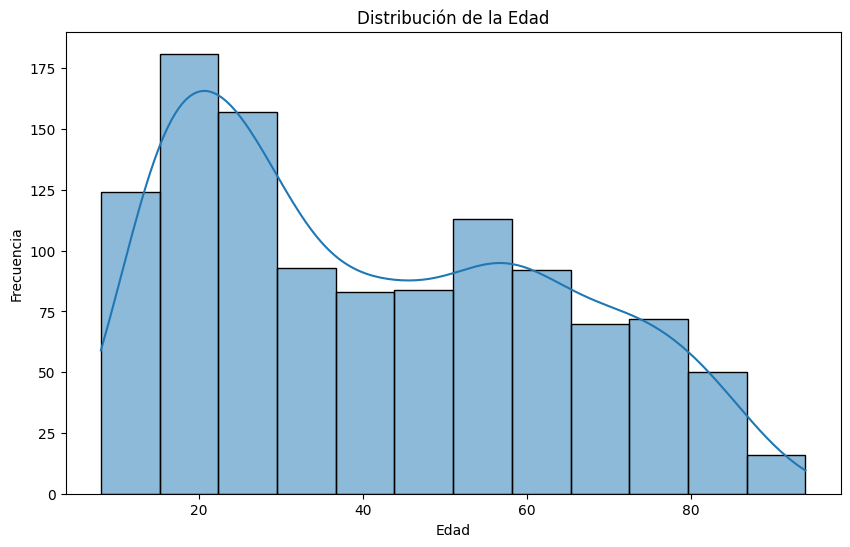

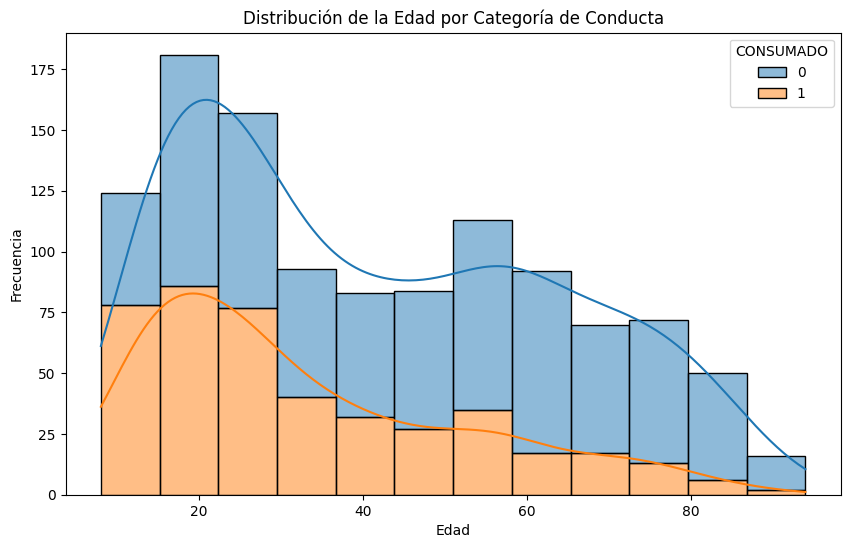

<ipython-input-2-0e2230d72e32>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CONSUMADO', y='EDAD', data=df, palette='Set2')


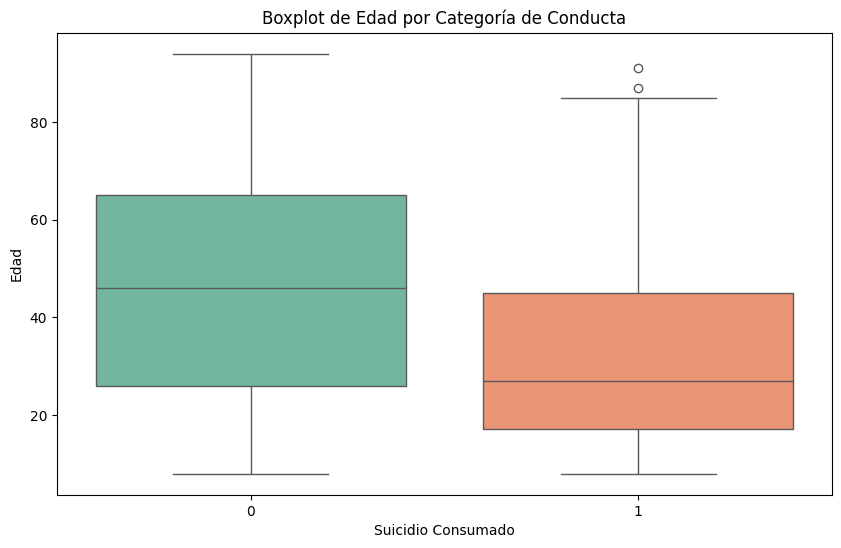

Cross-validation scores: [0.6043956  0.61538462 0.66483516 0.70718232 0.62430939]
Average cross-validation score: 0.6432214194645134
El umbral óptimo es: 0.37451070416158216
La matriz de confusión es: [[88 56]
 [22 61]]
El accuracy score es de: 65.63876651982379%
Intercept: [0.65210001]
Coeficiente: [('EDAD', -0.02912534603751331)]


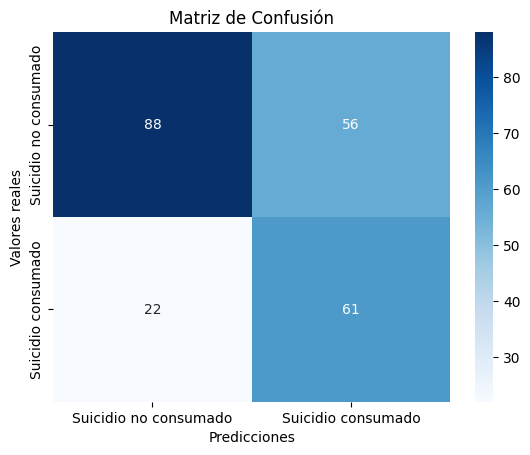

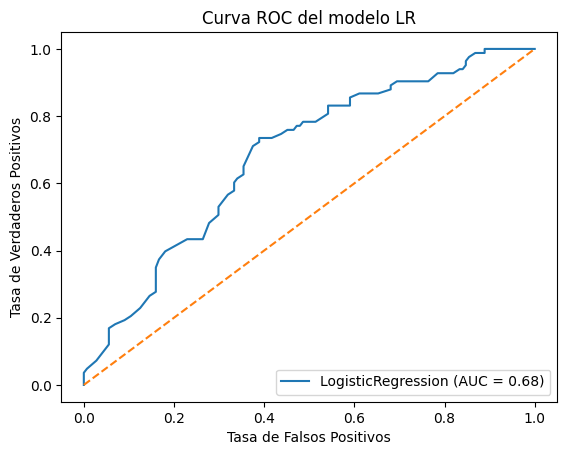

Optimization terminated successfully.
         Current function value: 0.620310
         Iterations 5
           2.5%     97.5%        OR
const  1.482260  2.650507  1.982105
EDAD   0.963995  0.977349  0.970649


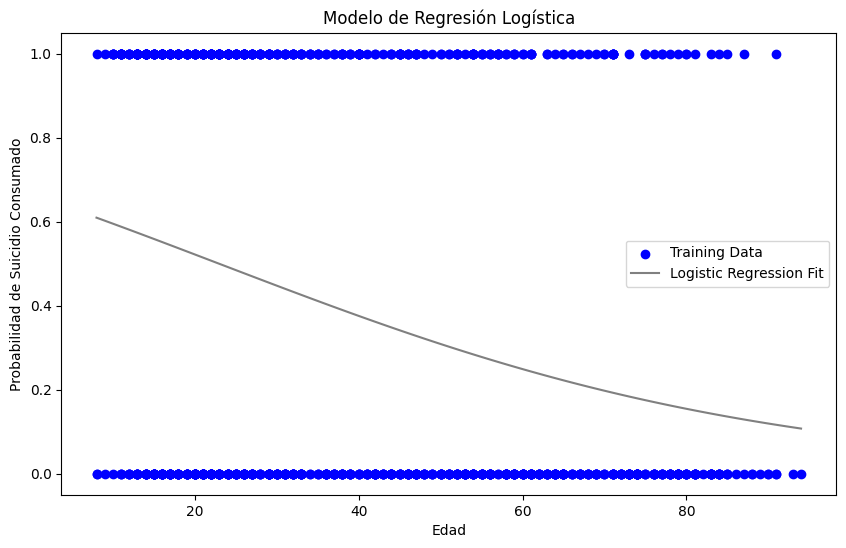

In [ ]:
# Tratamiento de datos
# ======================================================
import pandas as pd
import numpy as np
# Gráficos
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocesado y modelado
# ======================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay, roc_curve, auc
import statsmodels.api as sm

# Cargar y leer el banco de datos
# ======================================================
datos = pd.read_excel('data_ensayo.xlsx')

# Seleccionando las variables de interés
df = datos[['CLASIFICACION_DE_LA_CONDUCTA', 'EDAD']]
df['CONSUMADO'] = np.where(df['CLASIFICACION_DE_LA_CONDUCTA'] == 'Suicidio consumado', 1, 0)

# Análisis descriptivo
print(df.describe())
print(df['CONSUMADO'].value_counts())

# Histograma de la edad
plt.figure(figsize=(10, 6))
sns.histplot(df['EDAD'], kde=True)
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de distribución de la edad por categoría de conducta
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='EDAD', hue='CONSUMADO', kde=True, multiple='stack')
plt.title('Distribución de la Edad por Categoría de Conducta')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de la edad por categoría de conducta
plt.figure(figsize=(10, 6))
sns.boxplot(x='CONSUMADO', y='EDAD', data=df, palette='Set2')
plt.title('Boxplot de Edad por Categoría de Conducta')
plt.xlabel('Suicidio Consumado')
plt.ylabel('Edad')
plt.show()

# Dividir el conjunto en variable dependiente e independiente
X = df[['EDAD']]
y = df['CONSUMADO']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de hiperparámetros y validación cruzada
param_grid = [{'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.25, 0.5, 0.75, 1]},
              {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.25, 0.5, 0.75, 1]}]
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo después de la búsqueda de hiperparámetros
best_model = grid_search.best_estimator_

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_train, y_train, cv=stratified_kfold)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {np.mean(cv_scores)}')

# Entrenamiento del modelo final
best_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Encontrar el umbral óptimo
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'El umbral óptimo es: {optimal_threshold}')

# Clasificar las predicciones basadas en el umbral óptimo
y_pred_optimal = np.where(y_pred_prob >= optimal_threshold, 1, 0)

# Calcular la matriz de confusión y el accuracy
cm = confusion_matrix(y_test, y_pred_optimal)
ac = accuracy_score(y_test, y_pred_optimal)
print(f'La matriz de confusión es: {cm}')
print(f'El accuracy score es de: {100 * ac}%')

# Coeficientes del modelo
print("Intercept:", best_model.intercept_)
print("Coeficiente:", list(zip(X.columns, best_model.coef_.flatten())))

# Gráficos
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Suicidio no consumado", "Suicidio consumado"], yticklabels=["Suicidio no consumado", "Suicidio consumado"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Curva ROC del modelo LR')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.plot([0, 1], ls="--")
plt.show()

# Odds ratios e intervalos de confianza para los coeficientes
X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train.astype(float), X_train_const.astype(float))
result = logit_model.fit()

# Obtener los coeficientes, odds ratios e intervalos de confianza
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
conf['OR'] = np.exp(conf['OR'])
conf[['2.5%', '97.5%']] = np.exp(conf[['2.5%', '97.5%']])
print(conf)

# Gráfico del modelo
# Generar un rango de valores de edad para predecir
grid_X = np.linspace(X['EDAD'].min(), X['EDAD'].max(), 100).reshape(-1, 1)
grid_X_const = sm.add_constant(grid_X)
predicciones = result.predict(grid_X_const)

fig, ax = plt.subplots(figsize=(10, 6))
# Scatter plot de los datos de entrenamiento
ax.scatter(X_train['EDAD'], y_train, c='blue', label='Training Data')

# Plot de la curva de regresión logística
ax.plot(grid_X[:, 0], predicciones, color='gray', label='Logistic Regression Fit')

ax.set_title("Modelo de Regresión Logística")
ax.set_ylabel("Probabilidad de Suicidio Consumado")
ax.set_xlabel("Edad")
ax.legend(loc='best')
plt.show()

